In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [2]:
def load_data(city):
    labels = pd.read_csv('../data/dengue_labels_train.csv', parse_dates=True)
    features = pd.read_csv('../data/dengue_features_train.csv', parse_dates=True)

    all_data = pd.merge(labels, features, on=['city', 'year', 'weekofyear'])
    city_data = all_data[all_data.city == city]
    df = city_data.drop(['city', 'week_start_date'], axis=1)
    df = df.reset_index()
    df = df.drop(['index'], axis=1).sort_values(['year', 'weekofyear'], ascending=[True, True])

    # Move "total_cases" to column 0 to avoid bugs
    cols = list(df)
    cols.insert(0, cols.pop(cols.index('total_cases')))
    df = df.loc[:, cols]

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

def split_data(data, val_size):
    train_size = len(data)-val_size
    train = data[0:train_size]
    val  = data[train_size:train_size+val_size]
    return train, val

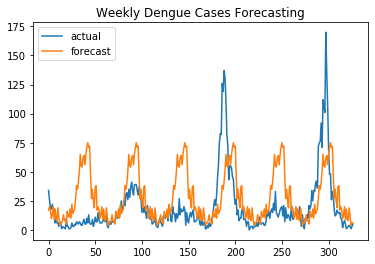

Naive Forecast Error: 18.571865443425075


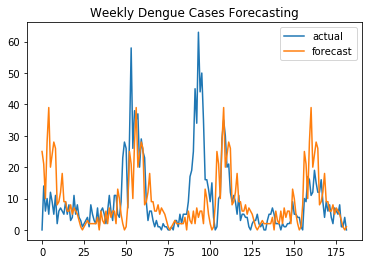

Naive Forecast Error: 6.93956043956044


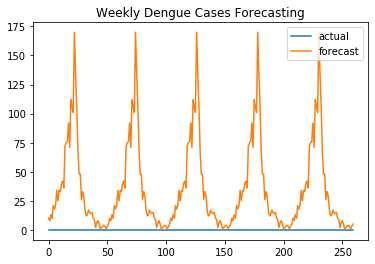

Naive Forecast Error: 36.11538461538461


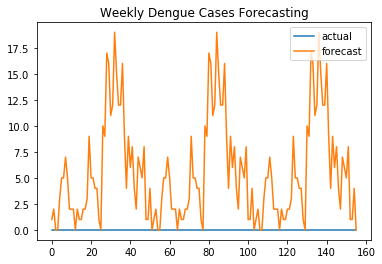

Naive Forecast Error: 5.6923076923076925


In [7]:
def naive_forecast(train, val):
    season_size = 52 # 1Year

    forecast = np.array([])
    while len(forecast) < len(val):
        forecast = np.concatenate((forecast, train[-season_size:]))
    forecast = forecast[:len(val)]

    plt.plot(val, label='actual')
    plt.plot(forecast, label='forecast')
    plt.title('Weekly Dengue Cases Forecasting')
    plt.legend()
    plt.show()
    
    error = mean_absolute_error(val, forecast)
    print("Naive Forecast Error: {}".format(error))
    
    return error, forecast

def naive_val_forecast(city):
    train_split_percent = 0.65
    data = load_data(city)['total_cases'].values
    val_size = int(math.floor((len(data)*(1-train_split_percent))))
    train, val = split_data(data, val_size)
    return naive_forecast(train, val)

def naive_test_forecast(city):
    train = load_data(city)['total_cases'].values
    test_df = pd.read_csv('../data/submission_format.csv', parse_dates=True)
    test_df = test_df[test_df['city'] == city]
    test = test_df['total_cases'].values
    test_df['total_cases'] = test
    naive_forecast(train, test)
    return test_df
    


naive_val_forecast('sj')
naive_val_forecast('iq')

sj_df = naive_test_forecast('sj')
iq_df = naive_test_forecast('iq')

In [8]:
submission_dataframe = pd.concat([sj_df, iq_df])
submission_dataframe.to_csv("submission_naive.csv", index=False)
import drivendata_validator.drivendata_validator as dd
v = dd.DrivenDataValidator()
v.validate('../data/submission_format.csv', 'submission_naive.csv')

,year,weekofyear,total_cases
city,,,
sj,2008,18,0
sj,2008,19,0
sj,2008,20,0
sj,2008,21,0
sj,2008,22,0
...,...,...,...
iq,2013,22,0
iq,2013,23,0
iq,2013,24,0
